In [1]:
import os
import sys
import math
import itertools
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

# Define paths
data_dir = Path("measurements")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Data resides in: {data_dir.resolve()}")

Running on: cpu
Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_4x4/measurements


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.normal_(self.W, std=0.01)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    # --- Energies ---
    def _free_energies_pair(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor):
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_f = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_f).sum(dim=-1)

        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        return (term1_v - term2_v), (term1_f - term2_f)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        F_v, F_f = self._free_energies_pair(v, b_mod, c_mod)
        stacked = torch.stack([-F_v, -F_f], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    # --- Gibbs Primitives ---
    def _sample_h_given_v(self, v_eff: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        p_h = torch.sigmoid((v_eff @ self.W + c_mod) / self.T)
        return torch.bernoulli(p_h, generator=rng)

    def _sample_v_given_h(self, a: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        p_v = torch.sigmoid((a + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    @staticmethod
    def _apply_flip(v: torch.Tensor, s0: torch.Tensor) -> torch.Tensor:
        return s0 * v + (1.0 - s0) * (1.0 - v)

    def _sample_s_given_v_h(self, v: torch.Tensor, a: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        vb   = (v * b_mod).sum(dim=-1)
        va   = (v * a).sum(dim=-1)
        bsum = b_mod.sum(dim=-1)
        asum = a.sum(dim=-1)
        dE = (-bsum - asum + 2.0 * vb + 2.0 * va)
        p_s0 = torch.sigmoid(dE / self.T)
        return torch.bernoulli(p_s0, generator=rng).to(v.dtype).unsqueeze(-1)

    def _gibbs_step_sym_fast(self, v: torch.Tensor, h: torch.Tensor, s0: torch.Tensor,
                             b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        # 1. h | v, s
        v_eff = self._apply_flip(v, s0)
        h = self._sample_h_given_v(v_eff, c_mod, rng)

        # 2. s | v, h (reuse a = Wh)
        a = h @ self.W.t()
        s0 = self._sample_s_given_v_h(v, a, b_mod, rng)

        # 3. v | h, s
        v_eff = self._sample_v_given_h(a, b_mod, rng)
        v_next = self._apply_flip(v_eff, s0)

        return v_next, h, s0

    # --- Forward / Inference ---
    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")

        b_mod, c_mod = self._compute_effective_biases(cond)
        v_model = v_data.clone()

        # Noise Injection
        n_noise = int(v_data.shape[0] * aux_vars.get("noise_frac", 0.1))
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(
                torch.full_like(v_model[:n_noise], 0.5), generator=rng
            )

        # Initialize Aux Vars for chain
        B = v_model.size(0)
        s0 = torch.bernoulli(torch.full((B, 1), 0.5, device=v_model.device, dtype=v_model.dtype), generator=rng)
        h = torch.zeros((B, self.num_hidden), device=v_model.device, dtype=v_model.dtype)

        for _ in range(self.k):
            v_model, h, s0 = self._gibbs_step_sym_fast(v_model, h, s0, b_mod, c_mod, rng)

        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = fe_data.mean() - fe_model.mean()
        return loss, {}

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, steps: int, rng: torch.Generator) -> torch.Tensor:
        """
        Generate samples starting from random noise.
        """
        B = cond.shape[0]
        b_mod, c_mod = self._compute_effective_biases(cond)

        # Start from uniform random
        v = torch.bernoulli(torch.full((B, self.num_visible), 0.5, device=cond.device), generator=rng)
        s0 = torch.bernoulli(torch.full((B, 1), 0.5, device=cond.device), generator=rng)
        h = torch.zeros((B, self.num_hidden), device=cond.device)

        # Thermalize
        for _ in range(steps):
            v, h, s0 = self._gibbs_step_sym_fast(v, h, s0, b_mod, c_mod, rng)

        return v

In [3]:
def compute_mz_abs(samples: torch.Tensor) -> Tuple[float, float]:
    spins_pm = 1.0 - 2.0 * samples.float()
    mz_per_sample = spins_pm.mean(dim=1)
    mz_abs = mz_per_sample.abs()
    total_mz = mz_abs.mean().item()
    total_mz_err = mz_abs.std(unbiased=True).item() / math.sqrt(samples.shape[0])
    return total_mz, total_mz_err

def compute_mx(samples: torch.Tensor, log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> Tuple[float, float]:
    B, N = samples.shape
    with torch.no_grad():
        log_scores_orig = log_score_fn(samples)
        total_ratios = torch.zeros(B, device=samples.device, dtype=torch.float32)

        # iterate over all sites and compute flip ratios
        for i in range(N):
            flipped_samples = samples.clone()
            flipped_samples[:, i] = 1 - flipped_samples[:, i]
            log_scores_flip = log_score_fn(flipped_samples)
            log_ratios = log_scores_flip - log_scores_orig
            total_ratios += torch.exp(log_ratios)

        avg_mx_per_sample = total_ratios / N
        total_mx = avg_mx_per_sample.mean().item()
        total_mx_err = avg_mx_per_sample.std(unbiased=True).item() / math.sqrt(B)
        return total_mx, total_mx_err

In [4]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train(model, optimizer, loader, num_epochs, rng, lr_schedule_fn):
    global_step = 0
    model.train()
    training_noise_frac = 0.1 # From new config

    print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
    print("-" * 30)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

        print(f"{epoch+1:<6} | {tot_loss/len(loader):+.4f}     | {lr:.6f}")

    return model

In [5]:
SIDE_LENGTH = 4
TRAIN_SAMPLES = 20_000   # New Config count
FILE_SAMPLES = 5_000_000 # Files usually available

# Using the detailed support list from the Magnetization notebook for better plots
h_support = [1.00, 1.50, 2.10, 2.80, 3.00, 3.30, 3.60, 4.00, 5.00, 6.00, 7.00]

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLES}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

# Verify existence
missing = [fp for fp in file_paths if not fp.exists()]
if missing:
    print(f"Warning: {len(missing)} files missing. Check generation.")

print(f"System Size       : {SIDE_LENGTH}x{SIDE_LENGTH}")
print(f"Training Samples  : {TRAIN_SAMPLES} per file")
print(f"Support Fields (h): {h_support}")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["h"], samples_per_file=[TRAIN_SAMPLES]*len(file_paths))

print(f"Samples Shape     : {tuple(ds.values.shape)}")
print(f"Conditions Shape  : {tuple(ds.system_params.shape)}")

System Size       : 4x4
Training Samples  : 20000 per file
Support Fields (h): [1.0, 1.5, 2.1, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]
Samples Shape     : (220000, 16)
Conditions Shape  : (220000, 1)


In [6]:
# TRAINING CONFIG (From New Model Notebook)
batch_size        = 1024
num_visible       = ds.num_qubits
num_hidden        = 64    # Upgraded from 16 to 64
conditioner_width = 64
num_epochs        = 50    # Increased epochs
k_steps           = 10    # Reduced CD-k steps (efficient training)

init_lr           = 1e-2
final_lr          = 1e-4

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator(device=device).manual_seed(SEED)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.005)

# Train using the new streamlined loop
model = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
              rng=rng, lr_schedule_fn=lr_schedule_fn)

Epoch  | Loss       | LR        
------------------------------
1      | +0.0309     | 0.010000
2      | +0.0146     | 0.010000
3      | +0.0029     | 0.010000
4      | +0.0027     | 0.010000
5      | +0.0091     | 0.010000
6      | +0.0084     | 0.010000
7      | +0.0083     | 0.010000
8      | +0.0049     | 0.010000
9      | +0.0026     | 0.010000
10     | +0.0006     | 0.010000
11     | +0.0038     | 0.010000
12     | +0.0033     | 0.010000
13     | +0.0057     | 0.010000
14     | +0.0053     | 0.010000
15     | +0.0054     | 0.010000
16     | +0.0040     | 0.009999
17     | +0.0077     | 0.009998
18     | +0.0035     | 0.009995
19     | +0.0084     | 0.009984
20     | +0.0040     | 0.009955
21     | +0.0050     | 0.009868
22     | +0.0078     | 0.009623
23     | +0.0035     | 0.008972
24     | +0.0053     | 0.007490
25     | +0.0028     | 0.005062
26     | +0.0017     | 0.002628
27     | -0.0026     | 0.001138
28     | -0.0052     | 0.000480
29     | -0.0003     | 0.000233
30     |

In [7]:
# EVALUATION
# Define novel points
h_novel = [1.8, 2.4, 2.6, 2.9, 3.1, 3.4, 3.8, 4.5, 5.5, 6.5]
sweep = sorted([(h, "support") for h in h_support] + [(h, "novel") for h in h_novel], key=lambda x: x[0])

eval_samples = 10_000
eval_steps = 100 # Mixing steps for evaluation (higher than training k)
rng_eval = torch.Generator(device=device).manual_seed(1234)

print("=== EVALUATION SWEEP ===")
results = []

for h_val, kind in sweep:
    cond_single = torch.tensor([[h_val]], device=device, dtype=torch.float32)
    cond_batch = cond_single.expand(eval_samples, -1)

    # Generate samples using the new symmetrized sampler
    samples = model.generate(cond_batch, eval_steps, rng_eval)

    # Scorer wrapper for Mx calculation
    scorer = lambda v: model.log_score(v, cond_batch)

    mz, _ = compute_mz_abs(samples)
    mx, _ = compute_mx(samples, scorer)

    results.append({"h": h_val, "type": kind, "mz": mz, "mx": mx})
    print(f"h {h_val:5.2f} [{kind:7}] | |Mz|: {mz:.5f} | Mx: {mx:.5f}")

df = pd.DataFrame(results).sort_values("h")

=== EVALUATION SWEEP ===
h  1.00 [support] | |Mz|: 0.96651 | Mx: 0.25525
h  1.50 [support] | |Mz|: 0.92206 | Mx: 0.38439
h  1.80 [novel  ] | |Mz|: 0.87840 | Mx: 0.46926
h  2.10 [support] | |Mz|: 0.81555 | Mx: 0.56313
h  2.40 [novel  ] | |Mz|: 0.71799 | Mx: 0.67399
h  2.60 [novel  ] | |Mz|: 0.63802 | Mx: 0.74476
h  2.80 [support] | |Mz|: 0.54996 | Mx: 0.81220
h  2.90 [novel  ] | |Mz|: 0.51199 | Mx: 0.83954
h  3.00 [support] | |Mz|: 0.47586 | Mx: 0.86239
h  3.10 [novel  ] | |Mz|: 0.43999 | Mx: 0.88561
h  3.30 [support] | |Mz|: 0.39341 | Mx: 0.91410
h  3.40 [novel  ] | |Mz|: 0.36775 | Mx: 0.92470
h  3.60 [support] | |Mz|: 0.34461 | Mx: 0.93877
h  3.80 [novel  ] | |Mz|: 0.32302 | Mx: 0.94963
h  4.00 [support] | |Mz|: 0.30721 | Mx: 0.95633
h  4.50 [novel  ] | |Mz|: 0.28868 | Mx: 0.96740
h  5.00 [support] | |Mz|: 0.26865 | Mx: 0.97588
h  5.50 [novel  ] | |Mz|: 0.26114 | Mx: 0.97969
h  6.00 [support] | |Mz|: 0.24708 | Mx: 0.98420
h  6.50 [novel  ] | |Mz|: 0.24144 | Mx: 0.98615
h  7.00 [suppor

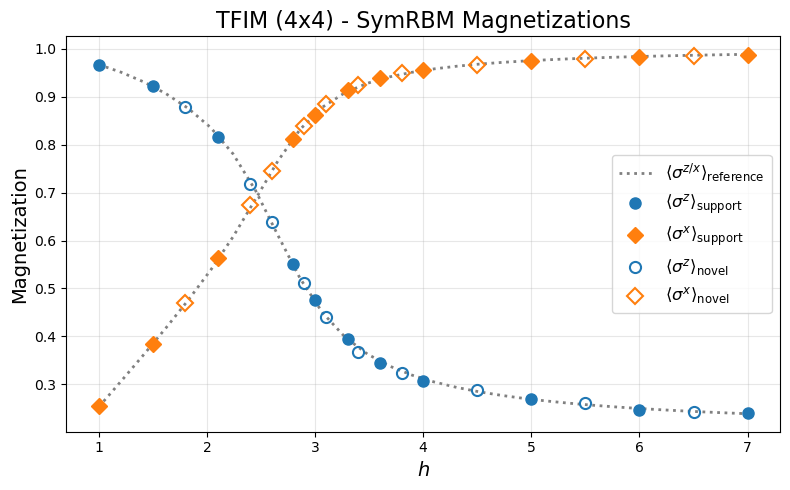

In [8]:
ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

supp = df[df["type"] == "support"]
nov = df[df["type"] == "novel"]

plt.figure(figsize=(8, 5))

if ref_df is not None:
    plt.plot(ref_df["h"], ref_df["mag_z"], ':', color='gray', linewidth=2.0, label='_nolegend_', zorder=1)
    plt.plot(ref_df["h"], ref_df["mag_x"], ':', color='gray', linewidth=2.0,
             label=r'$\langle \sigma^{z/x} \rangle_{\mathrm{reference}}$', zorder=1)

plt.plot(supp["h"], supp["mz"], 'o', color='C0', markersize=8,
         label=r'$\langle \sigma^z \rangle_{\mathrm{support}}$', zorder=2)
plt.plot(supp["h"], supp["mx"], 'D', color='C1', markersize=8,
         label=r'$\langle \sigma^x \rangle_{\mathrm{support}}$', zorder=2)

plt.plot(nov["h"], nov["mz"], 'o', color='C0', markerfacecolor='none',
         markersize=8, markeredgewidth=1.5, label=r'$\langle \sigma^z \rangle_{\mathrm{novel}}$', zorder=2)
plt.plot(nov["h"], nov["mx"], 'D', color='C1', markerfacecolor='none',
         markersize=8, markeredgewidth=1.5, label=r'$\langle \sigma^x \rangle_{\mathrm{novel}}$', zorder=2)

plt.xlabel(r'$h$', fontsize=14)
plt.ylabel('Magnetization', fontsize=14)
plt.title(f"TFIM ({SIDE_LENGTH}x{SIDE_LENGTH}) - SymRBM Magnetizations", fontsize=16)

plt.legend(frameon=True, fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_many.csv"
df.to_csv(file_name, index=False, float_format="%.6f")
print(f"\nSaved RBM magnetizations to: {os.path.abspath(file_name)}")


Saved RBM magnetizations to: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_4x4/tfim_4x4_magnet_many.csv
